In [3]:
import os
import sys

# Add the parent directory of the current script and 'src' folder to the path
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..")))

# Import the module
from src.model_unet_gelu import *

In [4]:
# Load your saved data
test_data = torch.load("../data/prepared_datasets/train_flowers.pt")
test_labels = torch.load("../data/prepared_datasets/train_flowers_labels.pt")
val_data = torch.load("../data/prepared_datasets/val_flowers.pt")
val_labels = torch.load("../data/prepared_datasets/val_flowers_labels.pt")
train_data = torch.load("../data/prepared_datasets/test_flowers.pt")
train_labels = torch.load("../data/prepared_datasets/test_flowers_labels.pt")

In [3]:
train_data.shape

torch.Size([6149, 3, 64, 64])

In [4]:
batch_size = 32

In [5]:
def prepare_data_loaders(train_data, train_labels, val_data, val_labels, test_data, test_labels, batch_size=batch_size):
    train_dataset = TensorDataset(train_data, train_labels)
    val_dataset = TensorDataset(val_data, val_labels)
    test_dataset = TensorDataset(test_data, test_labels)
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size)
    test_loader = DataLoader(test_dataset, batch_size=batch_size)
    
    return train_loader, val_loader, test_loader

In [6]:
# Normalize data to [0, 1] if not already done
train_data = (train_data - train_data.min()) / (train_data.max() - train_data.min())
val_data = (val_data - val_data.min()) / (val_data.max() - val_data.min())
test_data = (test_data - test_data.min()) / (test_data.max() - test_data.min())

train_data = train_data * 2 - 1
val_data = val_data * 2 - 1
test_data = test_data * 2 - 1
# Create data loaders
train_loader, val_loader, test_loader = prepare_data_loaders(train_data, train_labels, val_data, val_labels, test_data, test_labels)

In [11]:
from torch.optim import Adam
from torch.optim import AdamW

image_size = 64
channels = 3

device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

model = Unet(
    dim=image_size,
    channels=channels,
    dim_mults=(1, 2, 4,)
)
model.to(device)

#optimizer = Adam(model.parameters(), lr=5e-3)
#optimizer = AdamW(model.parameters(), lr=5e-3)
optimizer = Adam(model.parameters(), lr=1e-3)

cuda


In [12]:
timesteps = 200
betas = DiffusionSchedule.linear_beta_schedule(timesteps).clone()
diffusion_params = DiffusionSchedule.compute_diffusion_parameters(betas)

In [18]:
from torchvision.utils import save_image

epochs = 10
for epoch in range(epochs):
    for batch_idx, (data, _) in enumerate(tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}")):
        data = data.to(device)
        optimizer.zero_grad()

        #batch_size = batch["pixel_values"].shape[0]
        #batch = batch["pixel_values"].to(device)

        # Algorithm 1 line 3: sample t uniformally for every example in the batch
        t = torch.randint(0, timesteps, (batch_size,), device=device).long()
        if data.shape[0] == batch_size:
            
            loss = p_losses(model, data, t, loss_type="huber", diffusion_params=diffusion_params)
            
            if batch_idx % 100 == 0:
                print("Loss:", loss.item())
            
            loss.backward()
            optimizer.step()


Epoch 1/10:   1%|          | 1/193 [00:00<01:29,  2.15it/s]

Loss: 0.04879319667816162


Epoch 1/10:  52%|█████▏    | 101/193 [00:15<00:14,  6.34it/s]

Loss: 0.08731193840503693


Epoch 2/10:   1%|          | 1/193 [00:00<00:30,  6.39it/s]

Loss: 0.08398409932851791


Epoch 2/10:  52%|█████▏    | 101/193 [00:15<00:13,  6.63it/s]

Loss: 0.09085779637098312


Epoch 3/10:   1%|          | 1/193 [00:00<00:30,  6.25it/s]

Loss: 0.066733717918396


Epoch 3/10:  52%|█████▏    | 101/193 [00:15<00:13,  6.62it/s]

Loss: 0.07934048026800156


Epoch 4/10:   1%|          | 1/193 [00:00<00:27,  6.91it/s]

Loss: 0.048627808690071106


Epoch 4/10:  52%|█████▏    | 101/193 [00:15<00:13,  6.68it/s]

Loss: 0.060719531029462814


Epoch 5/10:   1%|          | 1/193 [00:00<00:30,  6.34it/s]

Loss: 0.04719936102628708


Epoch 5/10:  52%|█████▏    | 101/193 [00:15<00:13,  6.71it/s]

Loss: 0.04437143728137016


Epoch 6/10:   1%|          | 1/193 [00:00<00:30,  6.37it/s]

Loss: 0.05344374477863312


Epoch 6/10:  52%|█████▏    | 101/193 [00:15<00:13,  6.66it/s]

Loss: 0.06010980159044266


Epoch 7/10:   1%|          | 1/193 [00:00<00:28,  6.85it/s]

Loss: 0.05364537239074707


Epoch 7/10:  52%|█████▏    | 101/193 [00:15<00:13,  6.77it/s]

Loss: 0.04093392193317413


Epoch 8/10:   1%|          | 1/193 [00:00<00:28,  6.77it/s]

Loss: 0.06944242119789124


Epoch 8/10:  52%|█████▏    | 101/193 [00:15<00:13,  6.57it/s]

Loss: 0.05503499135375023


Epoch 9/10:   1%|          | 1/193 [00:00<00:28,  6.85it/s]

Loss: 0.06592869013547897


Epoch 9/10:  52%|█████▏    | 101/193 [00:14<00:13,  6.66it/s]

Loss: 0.05882641673088074


Epoch 10/10:   1%|          | 1/193 [00:00<00:29,  6.59it/s]

Loss: 0.04513287544250488


Epoch 10/10:  52%|█████▏    | 101/193 [00:15<00:14,  6.35it/s]

Loss: 0.04545477777719498


Epoch 10/10: 100%|██████████| 193/193 [00:29<00:00,  6.51it/s]


In [19]:
torch.save({
    'epoch': epochs,
    'batch_size':batch_size,
    'model_state_dict': model.state_dict(),
}, 'model_8.pth')

In [20]:
model = Unet(
    dim=image_size,
    channels=channels,
    dim_mults=(1, 2, 4,)
)
checkpoint = torch.load('model_8.pth')
state_dict = checkpoint['model_state_dict']
model.load_state_dict(state_dict)

model = model.to(device)

In [21]:
print(image_size,channels)
samples = sample(model, image_size=image_size, batch_size=batch_size, channels=channels, diffusion_params=diffusion_params)

64 3


sampling loop time step: 100%|██████████| 200/200 [00:09<00:00, 20.62it/s]


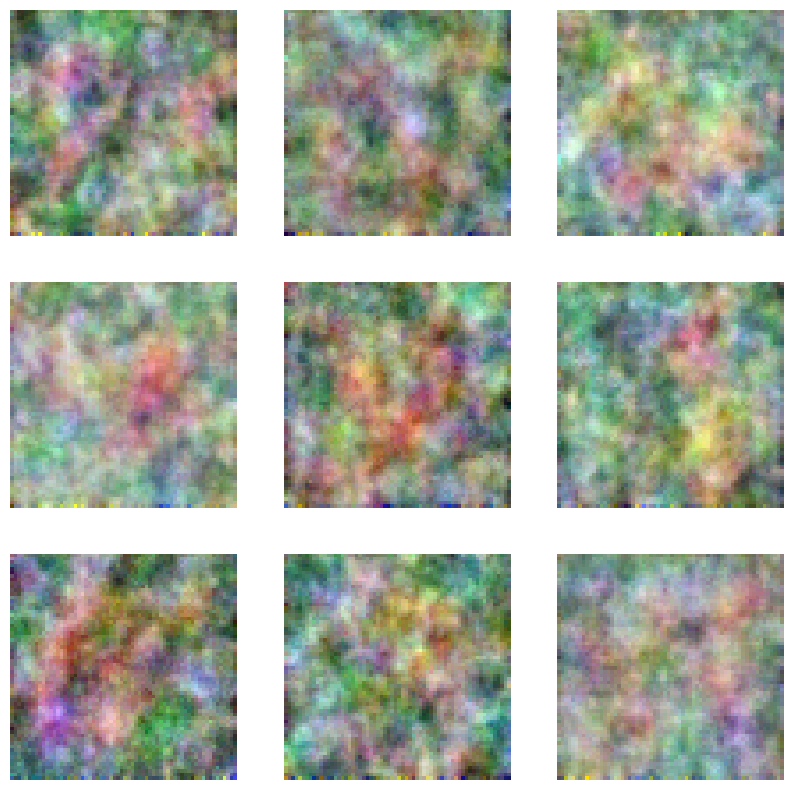

In [22]:
import numpy as np
num_images = 9

plt.figure(figsize=(10, 10)) 

for i in range(num_images):
    img = samples[-1][i] 
    img = img.cpu().numpy()
    img = np.transpose(img, (1, 2, 0)) 
    img = (img - img.min()) / (img.max() - img.min()) 

    plt.subplot(3, 3, i + 1)  # Create a 3x3 grid
    plt.imshow(img)
    plt.axis('off')  # Hide axis

    # Save the individual image with a unique name
    #plt.imsave(f"saved_image{i+1}.png", img)

#plt.tight_layout()
plt.show()

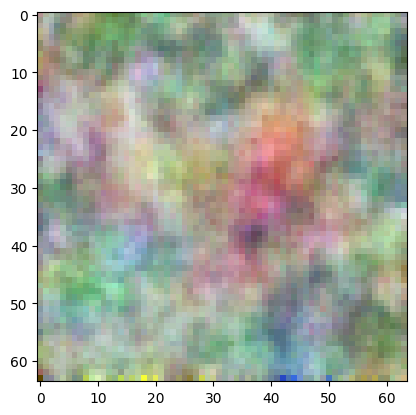

In [24]:
import matplotlib.animation as animation

random_index = 3

fig = plt.figure()
ims = []
#print(samples[2][0].shape)
for i in range(timesteps):
    img = samples[i][random_index]
    img = img.cpu().numpy()
    img = np.transpose(img, (1, 2, 0)) 
    #img = samples[i][random_index].reshape(image_size, image_size, channels)
    img = (img - img.min()) / (img.max() - img.min())
    im = plt.imshow(img, animated=True)
    ims.append([im])

animate = animation.ArtistAnimation(fig, ims, interval=50, blit=True, repeat_delay=1000)
#animate.save('diffusion_gelu.gif')
plt.show()

In [18]:
timesteps

200